In [1]:
import mouseQPCRModelSelection 
import numpy as np
import time
import AssignGPGibbsSingleLoop
import GPflow
import numpy as np
import time
import cPickle as pickle
import assigngp_dense
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
GPflow.__version__

'0.1.3'

In [3]:
Bpossible = np.linspace(2,70,3)
pt,Yall = mouseQPCRModelSelection.LoadMouseQPCRData(subsetSelection=2)
Y = Yall[:,0][None].T
print 'Y'
print Y.shape
strExp = 'MouseQPCR_Exp1'
m,mV = mouseQPCRModelSelection.InitModels(pt,Y)

Loaded data data/guo_ssData.p with nrowsXncols = (437, 2).
(437, 2)
(437,)
LoadMouseQPCRData output
(219, 2)
(219,)
Y
(219, 1)
Branching kernel =====================
unnamed.branchkernelparam.kern.variance transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.kern.lengthscales transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.Bv transform:(none) prior:None [FIXED]
[[ 1.]]
unnamed.white.variance transform:+ve prior:None
[ 1.]
Initialise models: MAP =====================
model.likelihood.variance transform:+ve prior:None
[ 1.]

model.kern.branchkernelparam.kern.variance transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.kern.lengthscales transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.Bv transform:(none) prior:None [FIXED]
[[ 1.]]
model.kern.white.variance transform:+ve prior:None
[ 1.]
Initialise models: VB =====================
compiling tensorflow function...
done


In [4]:
Bpossible=None
strSaveState='test'
fSoftVBAssignment=False
fOptimizeHyperparameters = False
fReestimateMAPZ=False
numMAPsteps = 10
D=Y.shape[1]
print D

1


In [5]:
# Do the MAP solution and plot assignments
Kbranch = m.kern
pt = mV.t
b = 20

Bcrap = np.atleast_2d(b) # crappy branch point

# reinitialise hyperparameters
Kbranch.white.variance = 1e-6
Kbranch.branchkernelparam.kern.lengthscales = 100 # 20 + (90. - b) / 2. # 65
Kbranch.branchkernelparam.kern.variance = 2 #0.0012 #  2.3158
m.likelihood.variance = 0.08
mV.likelihood.variance = m.likelihood.variance._array

# should recompute Kernel everytime we update kernel hyperparameters
m.CompileAssignmentProbability(fDebug=False,fMAP=True) 

# set branching point
m.kern.branchkernelparam.Bv = Bcrap 

print '============> B=' + str(m.kern.branchkernelparam.Bv._array.flatten())

# Random assignment for given branch point

np.random.seed(47)

randomAssignment = AssignGPGibbsSingleLoop.GetRandomInit(pt,Bcrap,m.indices)
print 'MAP assignment.'
(chainState, bestAssignment,_,condProbs) = \
    m.InferenceGibbsMAP(fReturnAssignmentHistory=True,fDebug=False,\
    maximumNumberOfSteps=numMAPsteps,\
    startingAssignment=list(randomAssignment))
    
    
# Very important!    
mV.kern.branchkernelparam.Bv.fixed = False
mV._compile()


============> B=[ 20.]
MAP assignment.
Performing MAP inference with B=[ 20.]
Converged after 2 iterations, lik=11.884
compiling tensorflow function...
done


In [6]:
m

Name,values,prior,constriant
model.likelihood.variance,[ 0.08],None,+ve
model.kern.branchkernelparam.kern.variance,[ 2.],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 100.],None,+ve
model.kern.branchkernelparam.Bv,[[ 20.]],None,(none)
model.kern.white.variance,[ 1.00000000e-06],None,+ve


In [7]:
mV

Name,values,prior,constriant
model.kern.branchkernelparam.kern.variance,[ 2.],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 100.],None,+ve
model.kern.branchkernelparam.Bv,[[ 20.]],None,(none)
model.kern.white.variance,[ 1.00000000e-06],None,+ve
model.likelihood.variance,[ 0.08],None,+ve
model.logPhi,"[[ 0.98159703 -0.37464725 -0.7125311 ..., 1.35949633 -1.11042881 -0.2600417 ] [-0.71781249 -0.95735761 -0.31622995 ..., 0.51073713 1.1035642 0.75378126] [-0.71525829 -1.43471397 0.65576598 ..., 0.15908624 0.45101311 -0.11680833] ..., [ 0.11950958 0.24571088 1.2296274 ..., -0.36192575 0.38231646 -0.30721951] [ 1.2333788 -0.98658856 -2.26171382 ..., 0.52942048 0.20704798 -0.77427696] [-0.60367689 -1.04474527 -1.71329155 ..., -1.40967526 -0.04817835 -1.5332027 ]]",None,(none)


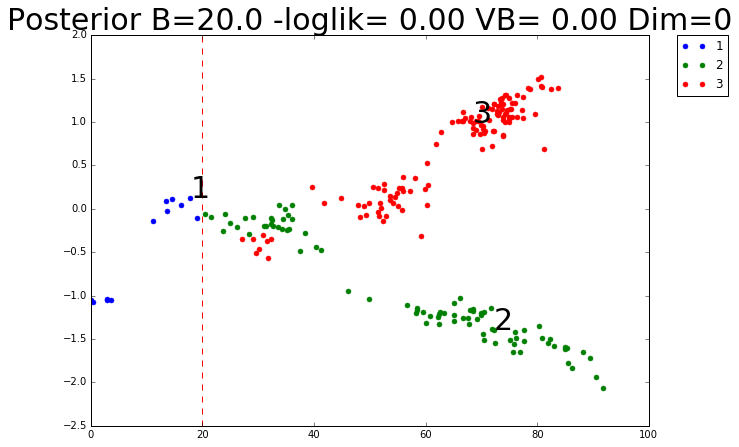

In [8]:
# Plot MAP solution
assigngp_dense.PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=5.,fs=30, \
                      mV=None, figsizeIn=(D*10,D*7),title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,0,0))

Variational kernel branch value [ 22.]
InitialisePhi:Warning switching to square transform
B=22.0. VB bound=345.14.
Variational kernel branch value [ 25.57894737]
InitialisePhi:Warning switching to square transform
B=25.5789473684. VB bound=342.84.
Variational kernel branch value [ 29.15789474]
InitialisePhi:Warning switching to square transform
B=29.1578947368. VB bound=336.74.
Variational kernel branch value [ 32.73684211]
InitialisePhi:Warning switching to square transform
B=32.7368421053. VB bound=323.75.
Variational kernel branch value [ 36.31578947]
InitialisePhi:Warning switching to square transform
B=36.3157894737. VB bound=313.86.
Variational kernel branch value [ 39.89473684]
InitialisePhi:Warning switching to square transform
B=39.8947368421. VB bound=313.04.
Variational kernel branch value [ 43.47368421]
InitialisePhi:Warning switching to square transform
B=43.4736842105. VB bound=313.15.
Variational kernel branch value [ 47.05263158]
InitialisePhi:Warning switching to squa

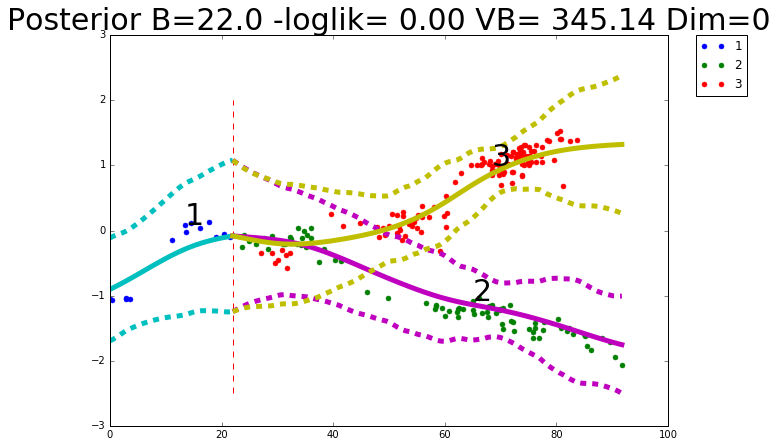

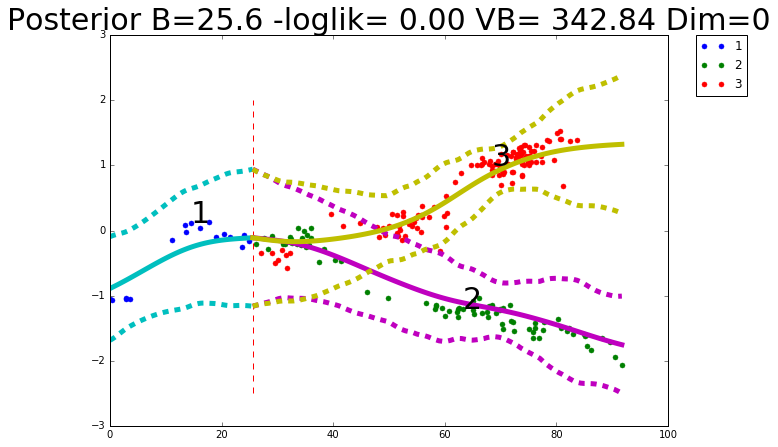

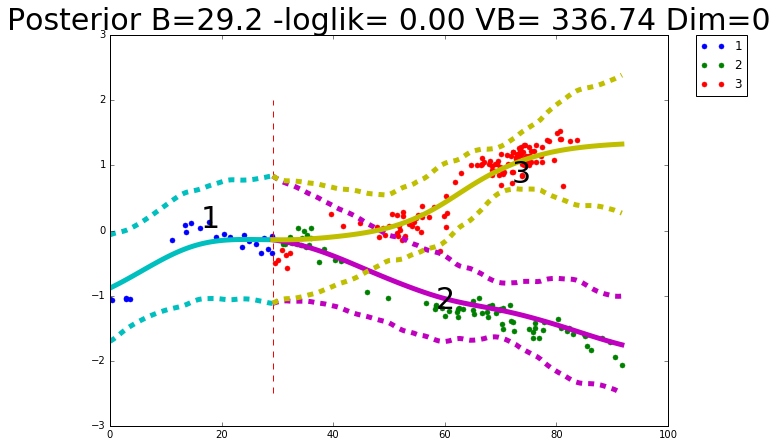

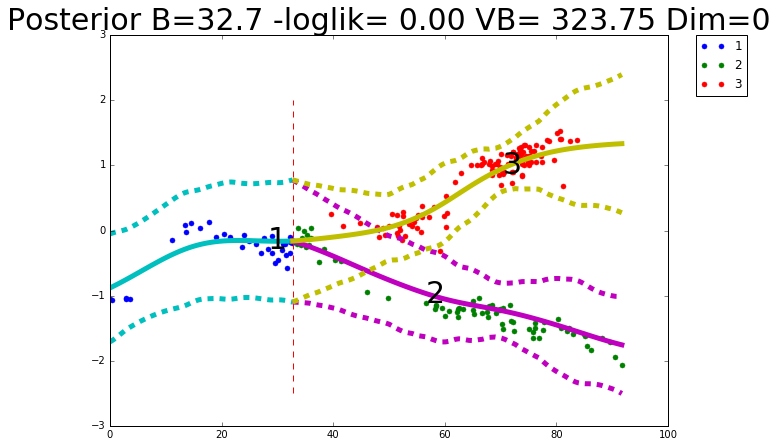

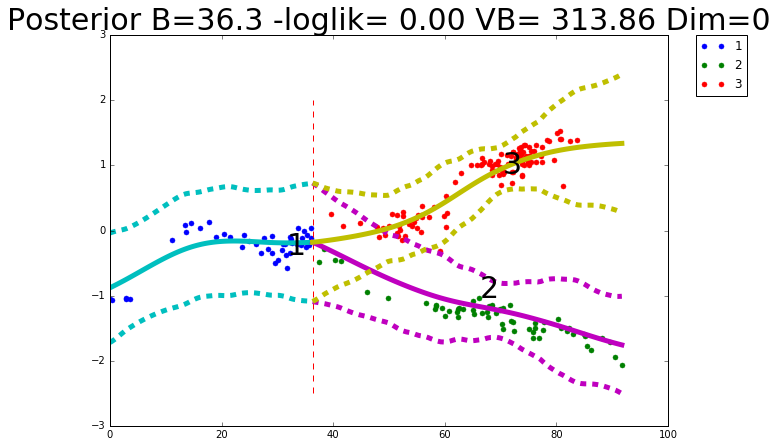

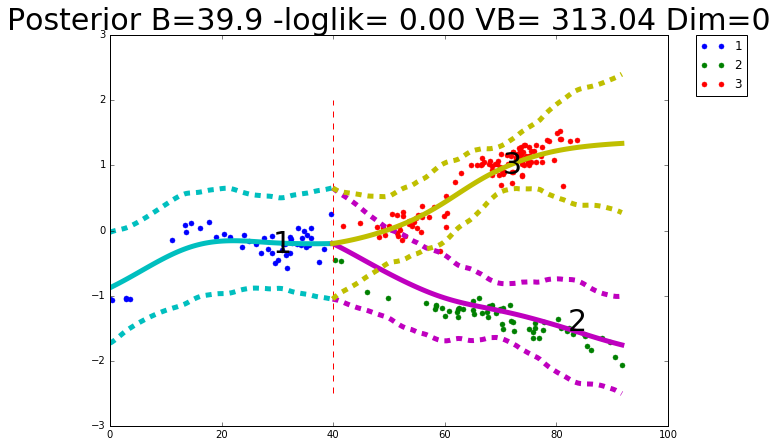

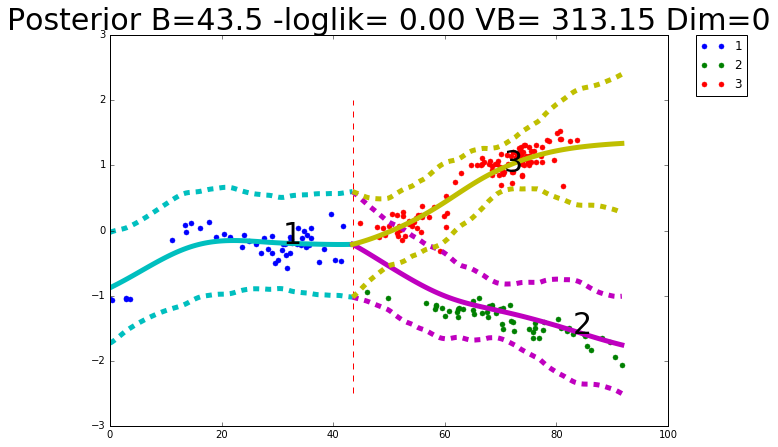

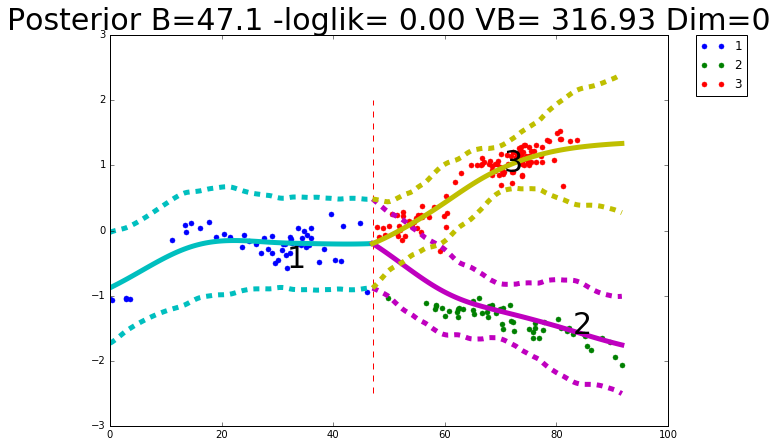

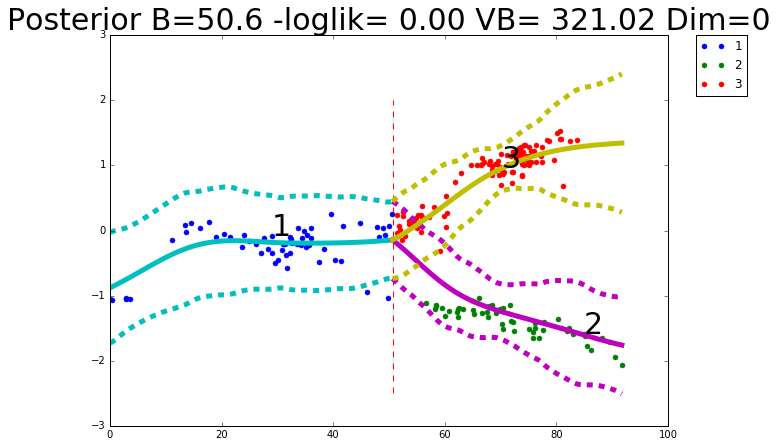

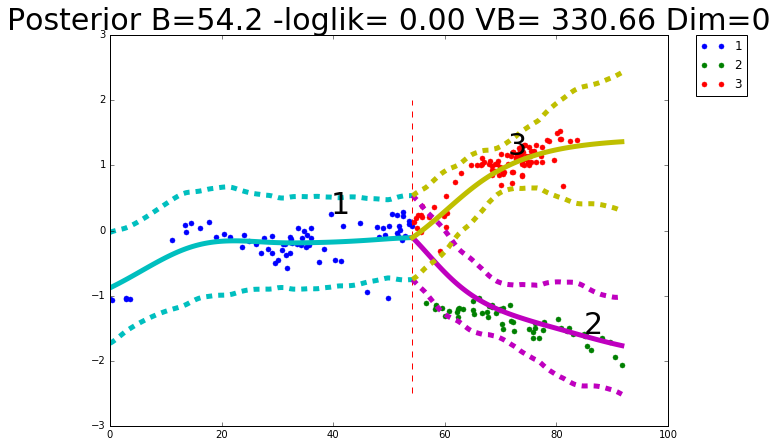

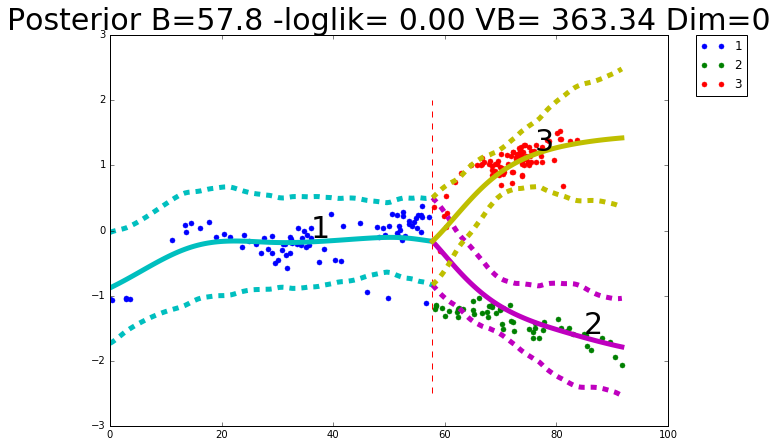

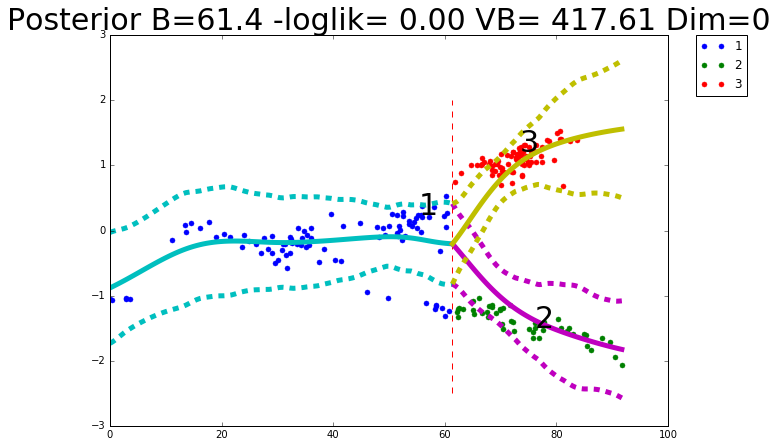

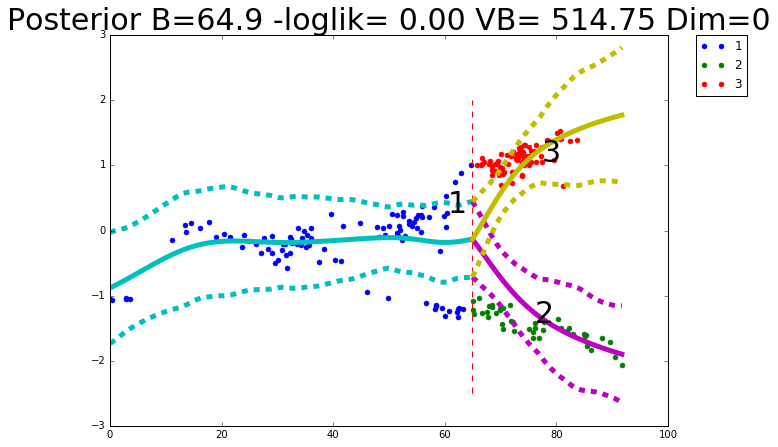

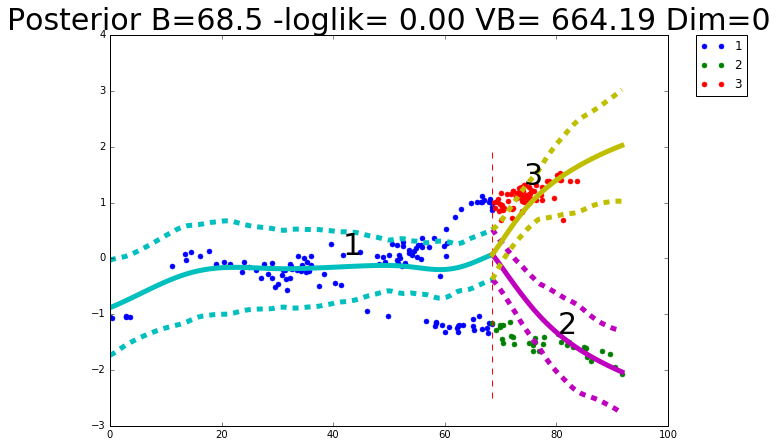

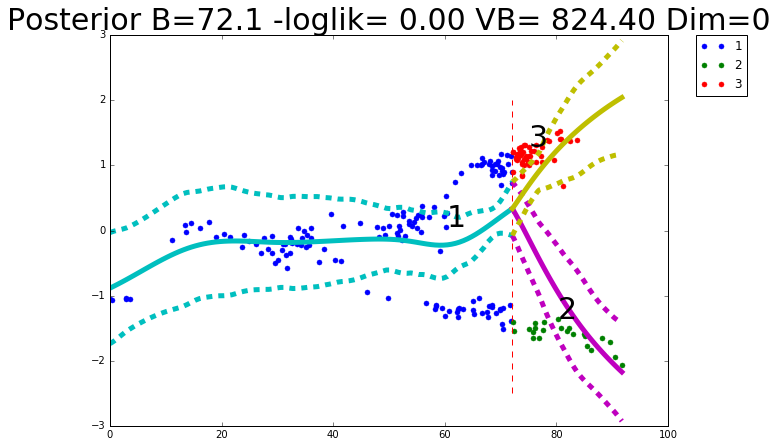

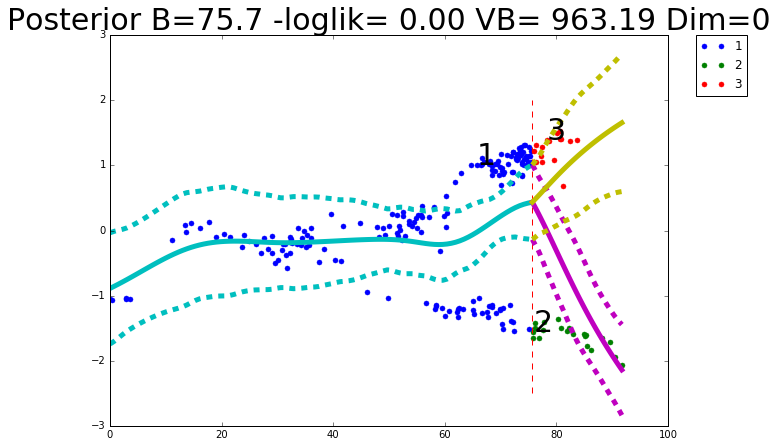

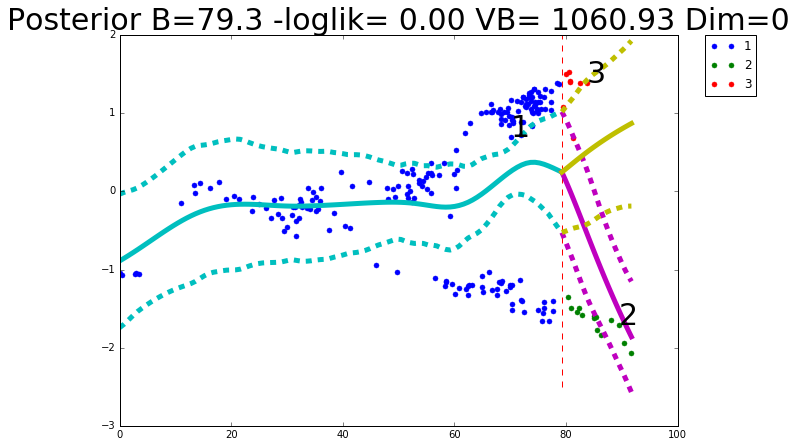

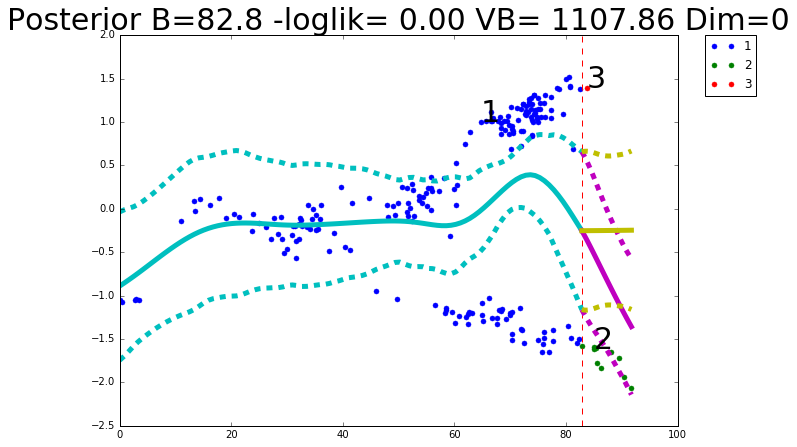

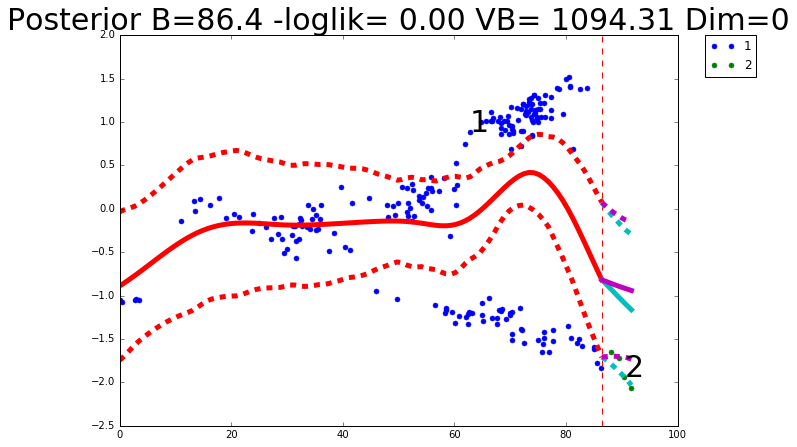

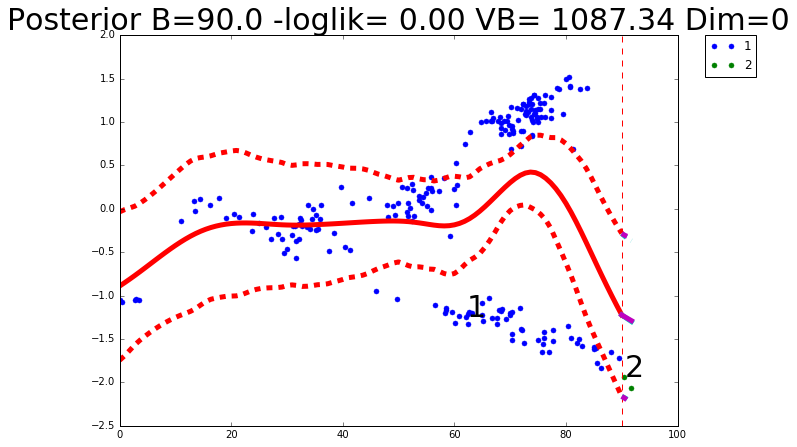

In [9]:
Bpossible = np.linspace(22,90,20)
logVBBound = []

Kbranch = m.kern
pt = mV.t

#mV.kern.branchkernelparam.Bv.fixed = False
#mV._compile()

for ib,b in enumerate(Bpossible):        
    Bcrap = np.atleast_2d(b) # crappy branch point

    # reset branching allocations for before branching point
    bestAssignmentCensored = list(bestAssignment)
    for i,bi in enumerate(bestAssignment):
        if mV.X[bi,0] < b :
            # before branching point 
            bestAssignmentCensored[i] = m.indices[i][0]
        
    # Variational bound computation
    mV.kern.branchkernelparam.Bv = Bcrap
    print 'Variational kernel branch value ' + str(mV.kern.branchkernelparam.Bv._array.flatten())
    # Set state for assignments
    
    fSoft = True
    if(fSoft):
        mV.InitialisePhi(m.indices, bestAssignmentCensored, b, condProbs, fSoftAssignment = True, fSoftUni = True)
    else:
        N = Y.shape[0]
        phiInitial = np.zeros((N, 3*N))
        phiInitial_invSoftmax = np.zeros((N, 3*N))  # large neg number makes exact zeros, make smaller for added jitter
        for i, n in enumerate(bestAssignmentCensored):
            phiInitial[i, n] = 1
            phiInitial_invSoftmax[i, n] = 10
        mV.logPhi = phiInitial_invSoftmax

    VBbound = mV._objective(mV.get_free_state())[0] # this is -log of bound
    logVBBound.append(VBbound)

    assigngp_dense.PlotSample(D, mV.X[bestAssignmentCensored, : ],3,Y,Bcrap,lw=5.,fs=30, \
                          mV=mV, figsizeIn=(D*10,D*7), title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,0,VBbound))



    print 'B=' + str(b) + '. VB bound=%.2f.'%(VBbound)    

In [10]:
mV.kern.branchkernelparam.Bv.fixed = True
mV.optimize(max_iters=24)

compiling tensorflow function...
done
optimization terminated, setting model state


      fun: array([ 298.58536798])
 hess_inv: <143887x143887 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.66208385e-02,  -1.23710331e-02,   2.49106505e-06, ...,
        -1.19066307e-04,   1.91224558e-07,   1.96967271e-07])
  message: 'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 27
      nit: 25
   status: 1
  success: False
        x: array([ 43.10009887,  72.38878841, -13.81628601, ...,   8.28111999,
        -9.01140127,  -9.01148593])

VB estimated B 39.8947368421 with marginal likelihood [ 313.03501818]


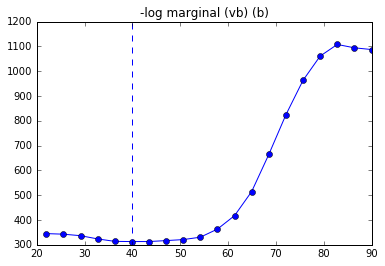

In [11]:
nlogL = np.array(logVBBound)
iMin = np.argmin(nlogL)
plt.plot(Bpossible[:len(logVBBound)],nlogL, '-ob')
plt.title('-log marginal (vb) (b)')

v=plt.axis()
minB = Bpossible[iMin]
plt.plot([minB,minB],v[-2:],'--b')

print 'VB estimated B ' + str(minB) + ' with marginal likelihood ' + str(logVBBound[iMin])

In [12]:
mV

Name,values,prior,constriant
model.kern.branchkernelparam.kern.variance,[ 43.10009887],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 72.38878841],None,+ve
model.kern.branchkernelparam.Bv,[[ 90.]],None,[FIXED]
model.kern.white.variance,[ 9.99224348e-07],None,+ve
model.likelihood.variance,[ 0.76300313],None,+ve
model.logPhi,"[[ 8.11625874 -9.01217442 -9.01211496 ..., -9.01170992 -9.01042273 -9.01036431] [-9.00977611 -9.01224577 -9.01218521 ..., -9.01179071 -9.01047787 -9.01041828] [-9.00975014 -9.01218082 -9.01212152 ..., -9.01171371 -9.01043069 -9.01037248] ..., [-9.01265879 -9.01168891 -9.01174886 ..., -9.00970321 -9.01133779 -9.01141981] [-9.01275096 -9.01170246 -9.01176531 ..., -9.00967904 -9.01138351 -9.01146895] [-9.01275607 -9.01172958 -9.01179175 ..., 8.28111999 -9.01140127 -9.01148593]]",None,(none)


In [13]:
print mV.GetPhi()


[[  9.99976084e-01   3.64087369e-08   3.64109018e-08 ...,   3.64256525e-08
    3.64725694e-08   3.64747002e-08]
 [  3.50430906e-08   3.49566529e-08   3.49587700e-08 ...,   3.49725640e-08
    3.50185072e-08   3.50205940e-08]
 [  3.63298732e-08   3.62416741e-08   3.62438232e-08 ...,   3.62586070e-08
    3.63051571e-08   3.63072706e-08]
 ..., 
 [  3.19069847e-08   3.19379456e-08   3.19360309e-08 ...,   3.20014276e-08
    3.19491615e-08   3.19465410e-08]
 [  3.13079380e-08   3.13407815e-08   3.13388118e-08 ...,   3.14042612e-08
    3.13507793e-08   3.13481008e-08]
 [  3.08571813e-08   3.08888722e-08   3.08869519e-08 ...,   9.99979724e-01
    3.08990148e-08   3.08963992e-08]]


In [14]:
mV

Name,values,prior,constriant
model.kern.branchkernelparam.kern.variance,[ 43.10009887],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 72.38878841],None,+ve
model.kern.branchkernelparam.Bv,[[ 90.]],None,[FIXED]
model.kern.white.variance,[ 9.99224348e-07],None,+ve
model.likelihood.variance,[ 0.76300313],None,+ve
model.logPhi,"[[ 8.11625874 -9.01217442 -9.01211496 ..., -9.01170992 -9.01042273 -9.01036431] [-9.00977611 -9.01224577 -9.01218521 ..., -9.01179071 -9.01047787 -9.01041828] [-9.00975014 -9.01218082 -9.01212152 ..., -9.01171371 -9.01043069 -9.01037248] ..., [-9.01265879 -9.01168891 -9.01174886 ..., -9.00970321 -9.01133779 -9.01141981] [-9.01275096 -9.01170246 -9.01176531 ..., -9.00967904 -9.01138351 -9.01146895] [-9.01275607 -9.01172958 -9.01179175 ..., 8.28111999 -9.01140127 -9.01148593]]",None,(none)


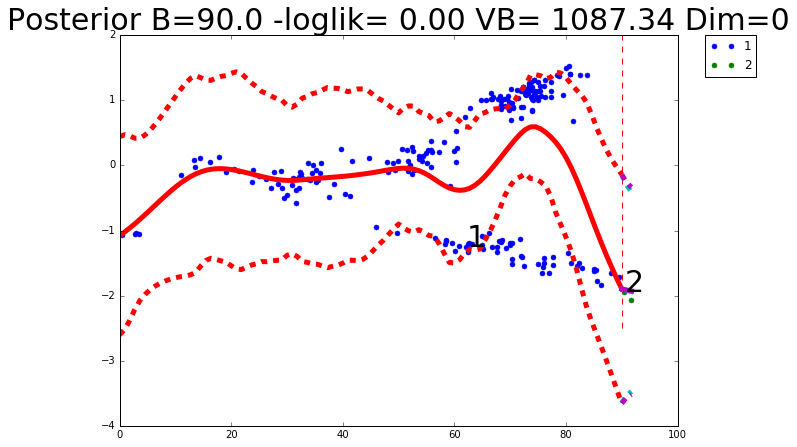

In [15]:

assigngp_dense.PlotSample(D, mV.X[bestAssignmentCensored, : ],3,Y,Bcrap,lw=5.,fs=30, \
                      mV=mV, figsizeIn=(D*10,D*7), title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,0,VBbound))




(array([ 143664.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0., 

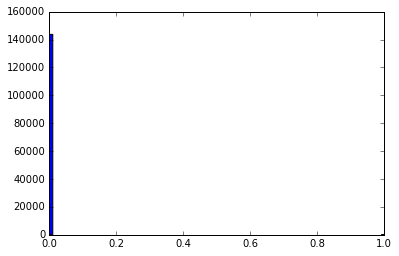

In [16]:
plt.hist(mV.GetPhi().flatten(), 100)

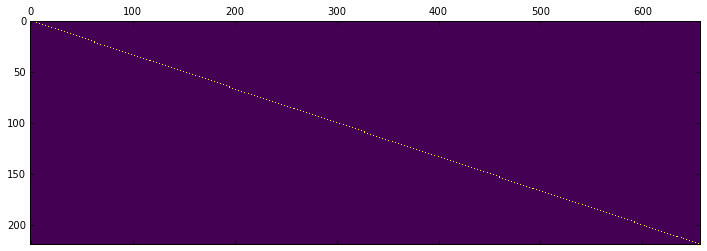

In [17]:
plt.matshow(mV.GetPhi(), cmap=plt.cm.viridis)